<a href="https://colab.research.google.com/github/berthine/Reinforcement-Learnin/blob/master/Correction_RL_1st_Hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull

Already up to date.


## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from gridworld import GridWorldWithPits

## Define the environment

In [0]:
from finite_env import FiniteEnv
import numpy as np

class RobotEnv(FiniteEnv):
    """
    Enviroment with 2 states and 3 actions
    Args:
        gamma (float): discount factor
        seed    (int): Random number generator seed
    """

    def __init__(self, gamma=0.5, seed=42):
        # Set seed
        self.RS = np.random.RandomState(seed)

        # Transition probabilities
        # shape (Ns, Na, Ns)
        # P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a)

        Ns = 2
        Na = 3
        
        P = np.array([[[1, 0], [3/4, 1/4], [1, 0]], [[0,1],[1,0], [1,0]]])
        self._R = np.array([[0,1,-0.5], [0, -1, 0]])

        self.state_decoder  = {0: "A", 1: "B"}
        self.action_decoder = {0: "WAIT", 1: "SEARCH", 2: "RECHARGE"}
        
        # Initialize base class
        states = np.arange(Ns).tolist()
        action_sets = [np.arange(Na).tolist()]*Ns
        super().__init__(states, action_sets, P, gamma)

    def reward_func(self, state, action, *_):
        return self._R[state, action]

    def reset(self, s=0):
        self.state = s
        return self.state

    def step(self, action):
        next_state = self.sample_transition(self.state, action)
        reward = self.reward_func(self.state, action, next_state)
        done = False
        info = {"str" : "In {} do {} arrive at {} get {}".format(
            self.state_decoder[state],
            self.action_decoder[action],
            self.state_decoder[next_state],
            reward )}
        self.state = next_state

        observation = next_state
        return observation, reward, done, info

    def sample_transition(self, s, a):
        prob = self.P[s,a,:]
        s_ = self.RS.choice(self.states, p = prob)
        return s_

    def render_policy(self, policy):
      if len(np.array(policy).shape) > 1:
        policy = densify_policy(policy)

      txt = ""
      for i, a in enumerate(policy):
        txt += "In state {} perform {}\n".format(self.state_decoder[i], self.action_decoder[a])
      return txt[:-1]

    @property
    def R(self):
        return self._R
  
env = RobotEnv()

Setting up the environment

In [0]:
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1): ", env.reward_func(0,1))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)
print(env.render_policy(policy))

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward, "   --> " + info["str"] if "str" in info else "") 
    if done:
        break
    state = next_state
print("")


Set of states: [0, 1]
Set of actions: [0, 1, 2]
Number of states:  2
Number of actions:  3
P has shape:  (2, 3, 2)
R has shape:  (2, 3)
discount factor:  0.5

initial state:  0
reward at (s=0, a=1):  1.0

random policy =  [0 0]
In state A perform WAIT
In state B perform WAIT
(s, a, s', r):
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0
0 0 0 0.0    --> In A do WAIT arrive at A get 0.0



## Useful functions


In [0]:
def sparsify_policy(policy, Na):
  ### Turn a dense policy into a sparse one.
  #  Ex: [0, 1], Na=2  -> [[1, 0, 0], [0, 1, 0]]
  ###

  Ns = len(policy)
  sparse_policy = np.zeros(shape=(Ns, Na))
  for i, a in enumerate(policy):
    sparse_policy[i,a]=1
  return sparse_policy

def densify_policy(policy):
  ### Turn a sparse determinist policy into a dense one.
  #  Ex: [[1, 0, 0], [0, 1, 0]] -> [0, 1]
  ###
  return np.array(policy).argmax(axis=1)


## Exercice : Policy Evaluation
1. Evaluate the policy by solving the linear system
2. Evaluate the policy through recursion

In [0]:
# Policy evaluation (exact)

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma


# Policy to evaluate
# State A: Search
# State B: Wait
dpi = np.array([1, 0])
pi = sparsify_policy(dpi, Na=env.Na)
print("## old pi:")
print(pi)
print(env.render_policy(pi))

# states = [0, 1]
# actions = [0, 1, 2]
# Ppi = np.zeros([2,2])
# for s in states:
#   for s_next in states:
#     Ppi[s, s_next] = np.sum(pi[s] * P[s, :, s_next]) 

# Compute the dynamics given the policy
Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(R * pi, axis=1) #Note, we assume that R(s,a) does not depend of the next state

# Evaluate the policy
Vpi = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)
print("## Vpi: ")
print(Vpi)


# # Compute the Q values
Qpi = R + gamma * P.dot(Vpi)

# print("## Qpi:")
print("## Qpi: ")
print(Qpi)


# # What is the next policy if we perform one step of policy improvment ?
dpi_new = Qpi.argmax(axis=1)

# print("## new pi:")
print("## pi: ")
print(sparsify_policy(dpi_new, Na=env.Na))
print(env.render_policy(dpi_new))

## old pi:
[[0. 1. 0.]
 [1. 0. 0.]]
In state A perform SEARCH
In state B perform WAIT
## Vpi: 
[1.6 0. ]
## Qpi: 
[[ 0.8  1.6  0.3]
 [ 0.  -0.2  0.8]]
## pi: 
[[0. 1. 0.]
 [0. 0. 1.]]
In state A perform SEARCH
In state B perform RECHARGE


In [0]:
states = [0, 1]
actions = [0, 1, 2]
Ppi = np.zeros([2,2])
for s in states:
  for s_next in states:
    Ppi[s, s_next] = np.sum(pi[s] * P[s, :, s_next])
Ppi 

array([[0.75, 0.25],
       [0.  , 1.  ]])

In [0]:
# Policy evaluation (recursive)

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma

# Policy to evaluate
dpi = np.array([1, 0])
pi = sparsify_policy(dpi, Na=env.Na)

# Compute the dynamics given the policy
Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(R * pi, axis=1) 

# Stopping criterion -> maximum number of steps
epsilon = 1e-3
r_max = np.max(R)
max_k = int(np.log(r_max/epsilon)/np.log(1/gamma))+1

v = np.array([-1, 1])
print("0:", v)
for k in range(max_k):
  v = Rpi + gamma*Ppi.dot(v)
  print("{}:".format(k), v)

print()

# Stopping criterion -> compute the infinite norm
v_new = np.array([-1, 1])
v_old = np.array([2*epsilon, 0])
k = 1
print("0:", v_new)
while np.absolute(v_new-v_old).max() > epsilon:
  v_old = v_new
  v_new = Rpi + gamma*Ppi.dot(v_new)
  print("{}:".format(k), v_new)
  k += 1



0: [-1  1]
0: [0.75 0.5 ]
1: [1.34375 0.25   ]
2: [1.53515625 0.125     ]
3: [1.59130859 0.0625    ]
4: [1.60455322 0.03125   ]
5: [1.60561371 0.015625  ]
6: [1.60405827 0.0078125 ]
7: [1.60249841 0.00390625]
8: [1.60142519 0.00195312]
9: [1.60077859e+00 9.76562500e-04]

0: [-1  1]
1: [0.75 0.5 ]
2: [1.34375 0.25   ]
3: [1.53515625 0.125     ]
4: [1.59130859 0.0625    ]
5: [1.60455322 0.03125   ]
6: [1.60561371 0.015625  ]
7: [1.60405827 0.0078125 ]
8: [1.60249841 0.00390625]
9: [1.60142519 0.00195312]
10: [1.60077859e+00 9.76562500e-04]


## New Environment!!!

In [0]:
# New Maze environment
# s: start
# g: goal
# x: negative reward state

grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]

env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)

In [0]:
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.R.shape)  
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1,s'=1): ", env.reward_func(0,1,1))
print("")

# A random policy
dpi = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", dpi)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = dpi[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward) 
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 12)
Set of actions: [0, 1, 2, 3]
Number of states:  12
Number of actions:  4
P has shape:  (12, 4, 12)
R has shape:  (12, 4)
discount factor:  0.99

initial state:  8
reward at (s=0, a=1,s'=1):  -2.0

random policy =  [2 2 0 3 0 2 0 0 2 2 2 1]
(s, a, s', r):
8 2 8 -2.0
8 2 8 -2.0
8 2 8 -2.0
8 2 8 -2.0



In [0]:
dpi = np.random.randint(env.Na, size = (env.Ns,))
env.render_policy(dpi)

state = env.reset()
env.render()
for i in range(5):
    action = dpi[state]
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
      break

+-------+
|^:v:>:^|
|<:v:v:^|
|>:v:>:>|
+-------+
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (down)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (down)
+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (down)


## Exercice: Value Iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $V_1 = TV_0, \; V_0\in \mathbb{R}^{S}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
# useful function
def plot_infnorm(lst, star, name="V"):
  
  lst = np.array(lst)
  star = np.array(star)

  # Compute inf norm
  diff = np.absolute(lst - star).max(axis=1)
  plt.figure()
  plt.plot(diff)
  plt.xlabel('Iteration')
  plt.ylabel('Error')
  plt.title("||{} - {}*||_inf".format(name, name))

def plot_norm2(lst, star, name="V"):
  
  lst = np.array(lst)
  star = np.array(star)

  # Compute l2 norm
  diff = np.linalg.norm(lst - star, ord=2)
  plt.figure()
  plt.plot(diff)
  plt.xlabel('Iteration')
  plt.ylabel('Error')
  plt.title("||{} - {}*||_inf".format(name, name))

+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
v (last): [-12.51900447 -10.53807754  -8.18223708  -6.09482131 -14.74986553
 -30.46943697 -10.48755342  -8.17632202 -16.28042498 -14.3886304
 -12.14153371 -10.18561434]
v (star): [-16.14241424 -14.14833522 -11.78735625  -9.70420747 -18.37607865
 -34.09268495 -14.09758906 -11.78144235 -19.90323987 -18.01512775
 -15.76496054 -13.79583079]
|v - v_star|_inf:  3.626497356300213


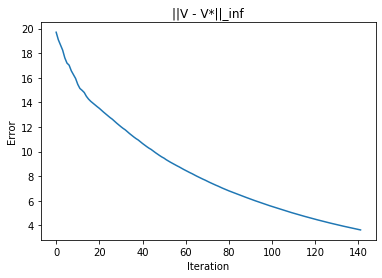

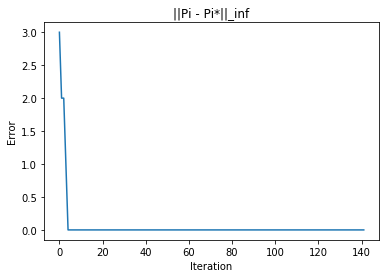

In [0]:
# Compute Value Iteration

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 5e-2

# Prepare v, and storage
v = np.zeros(env.Ns)
v_all = []
pi_all = []

# iterate over the value
while True:
  
  # Compute v_k
  v, v_old = np.max(R + gamma * P.dot(v), axis=1), v
  v_all.append(v)

  # Esimate Intermediate policy
  q = R + gamma * P.dot(v)
  dpi = q.argmax(axis=1)

  pi_all.append(dpi)

  # stopping criterion 
  if np.absolute(v-v_old).max() < epsilon: 
    break

# Plot optimal policy
env.render_policy(dpi)

# You need to evaluate V* here from your optimal policy
# You have no guarantee that the last v-value is converge to the actual Vpi
pi = sparsify_policy(dpi, Na=env.Na)
Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(R * pi, axis=1)

v_star = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)
print("v (last):", v_all[-1])
print("v (star):", v_star)

# The difference is not exactly epsilon. We here we are comparing V*-V while the algorithm we are comparing V_new - V_old
print("|v - v_star|_inf: ", np.absolute(v_all[-1]-v_star).max())

# The value function converge towards v* iteration after iteration
plot_infnorm(v_all, v_star, name="V")

# If we estimate intermediate policy, we observe that we good policy is obtained earlier in the process.
# However, the value function have not yet converge, so we cannot say for sure at iteration X that is the optimal policy
plot_infnorm(pi_all, dpi, name="Pi")


[-16.04439862 -14.0503196  -11.68934063  -9.60619184 -18.27806303
 -33.99466932 -13.99957344 -11.68342673 -19.80522424 -17.91711212
 -15.66694491 -13.69781517]
+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
v (last): [-16.04340856 -14.04932954 -11.68835057  -9.60520179 -18.27707297
 -33.99367926 -13.99858338 -11.68243667 -19.80423418 -17.91612207
 -15.66595485 -13.69682511]
v (star): [-16.14241424 -14.14833522 -11.78735625  -9.70420747 -18.37607865
 -34.09268495 -14.09758906 -11.78144235 -19.90323987 -18.01512775
 -15.76496054 -13.79583079]

epsilon 0.001
v (diff max): 0.09900568774535401


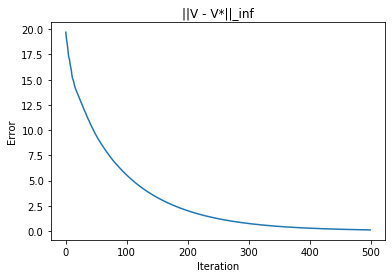

In [0]:
# Compute Value Iteration

# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 1e-3

# Prepare v, and storage
v = np.zeros(env.Ns)
v_all = []

while True:

  v_old = v
  v = np.max(R + gamma*P.dot(v), axis=1)

  if np.absolute((v-v_old)).max() < epsilon:
    break  # I got V* :-) 

  v_all.append(v)

print(v) # this is V*
Q = R + gamma*P.dot(v)
dpi = Q.argmax(axis=1)

env.render_policy(dpi)


pi = sparsify_policy(dpi, Na=env.Na)
Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(R * pi, axis=1)

v_star = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)
print("v (last):", v_all[-1])
print("v (star):", v_star)
print()
print("epsilon", epsilon)
print("v (diff max):", np.max(np.absolute(v_star-v_all[-1])))

plot_infnorm(v_all, v_star, name="V")


## Exercice: Policy Iteration (Homework)

# Remarks !!! 

Maximum score is 3

The mark is computed as follow:
- No code: -3pts
- The code is not running: -2.5pts
- Rpi /Ppi are not correctly computed/used:	-1.5pts
- The stopping condition is wrong: -1pt

The common mistakes are the following:

\\
**Mistake one:** *Wrong stopping criterion*

In *policy iteration*, the stoping criterion is $\pi_{old}(s) = \pi_{new}(s) \;\forall s\in S$. In other words, *the policy is not changing anymore*. There is no policy improvement step. The good implementation is `np.equal(pi_old, pi_new) `

In *value-iteraton*, the stopping criterion is $\|V_n - V^\star\|_{\infty} < \epsilon$. In other words, the *value function is not changing anymore* within an $\epsilon$.

In many cases, people confuses the two stopping criterions. The code checks whether $\|\pi_{old} - \pi_{new}\|_{\infty} < \epsilon$. Thus, the implementation `np.absolute((pi_new-pi_old)).max() < epsilon` is wrong. For instance, if i set epsilon to 2 (why not!), then you can see that the stopping criterion does not make sense anymore.

\\
**Mistake two:** *Mixture between Value-iteration and Policy iteration*

Some people implemented the following code:

```
  v = (R + gamma * np.dot(P, v)).max(axis=1)  # (1)
  q = R + gamma * np.dot(P, v)                # (2)
  dpi = np.argmax(axis=1)                     # (3)
```

(1) is not an policy evaluation step. It is a value-improvment step that is used in value-iteration. Therefore, there is no guarantee that q would change on the next iteration. You sometimes need several value-improvment step to lead to change of policy. 
As a reminder, 
 - policy iteration: evaluate the policy, then improve the policy
 - vale-iteration: keep improving the value-function. Once it converge, compute the optimal policy

It does not make sense to perform both value-improvment and policy improvment together. (As the value function is in a stale state)


+-------+
|<:<:<:<|
|<:<:<:<|
|<:<:<:<|
+-------+
None
+-------+
|<:<:>:>|
|^:^:^:^|
|v:<:<:<|
+-------+
None
+-------+
|<:>:>:>|
|^:>:>:^|
|v:<:^:^|
+-------+
None
+-------+
|>:>:>:>|
|^:>:>:^|
|^:>:>:^|
+-------+
None
+-------+
|>:>:>:>|
|^:>:>:^|
|>:>:>:^|
+-------+
None
v (star): -197.60926714941917


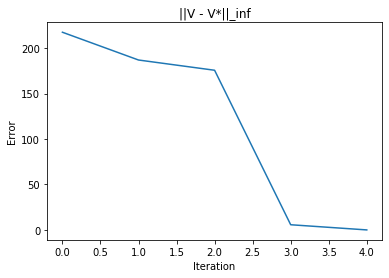

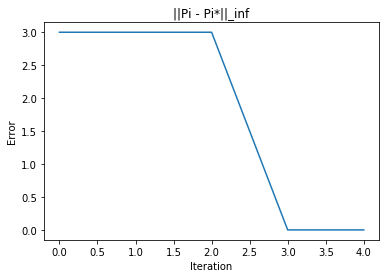

In [0]:
# Retrieve the environment MDP
P = env.P
R = env.R
gamma = env.gamma
epsilon = 5e-2

#Initialize policy
dpi = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
print(env.render_policy(dpi))

v_all = []
pi_all = []

while True:

  # Sparsify policy to perform matrix operation
  pi = sparsify_policy(dpi, Na=env.Na)

  # Compute new transition/reward conditioned on the policy
  Ppi = np.sum(P * np.expand_dims(pi, axis=-1), axis=1)
  Rpi = np.sum(R * pi, axis=1) 

  # Evaluate value function
  v = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)

  # Evaluate Q-function
  q = R + gamma * P.dot(v)

  # Update the policy
  dpi, old_pi = q.argmax(axis=1), pi

  # Storage
  v_all.append(v)
  pi_all.append(dpi)

  pi = sparsify_policy(dpi, Na=env.Na)

  # Check if the two policies are equal
  if np.array_equal(pi, old_pi):
      break

  print(env.render_policy(dpi))

print("v (star):", v.sum())
plot_infnorm(v_all, v, name="V")
plot_infnorm(pi_all, dpi, name="Pi")

## Exercice: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, learning_rate, epsilon, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.ones((env.Ns, env.Na))
    
    def sample_action(self, state, greedy=False):
        epsilon = min(
            self.epsilon / math.sqrt(self.Nsa[state].min()),
            self.min_epsilon)
        
        # explore
        if not greedy and np.random.uniform(0, 1) < epsilon:
          return np.random.choice(self.env.actions)

        # exploit
        else:
          action = self.Q[state, :].argmax()
          return self.env.actions[action]
        
    
    def update(self, state, action, next_state, reward, done):
        alpha = self.learning_rate / math.sqrt(self.Nsa[state, action])
        
        if not done:
          max_q = self.Q[next_state, :].max()
        else:
          max_q = 0.  # We do not bootstrap further
        
        q = self.Q[state, action]
        increment = (reward + self.gamma*max_q) - q

        # Update
        self.Q[state, action] = self.Q[state, action] + alpha*increment
        self.Nsa[state, action] += 1


In [0]:
q_learning = QLearning(env, gamma=env.gamma, learning_rate=1, epsilon=0.6, min_epsilon=0.1)

# Define storage and variable
q_all = []
r_all = []
pi_all = []
max_steps = int(5e4)


# main algorithmic loop
state = env.reset()
for t in range(max_steps):
    
  # Sample the action
  action = q_learning.sample_action(state, greedy=False)
  
  # Sample the environment
  next_state, reward, done, _ = env.step(action)
  
  # Update q-function
  q_learning.update(state=state, action=action, next_state=next_state, reward=reward, done=done)

  # Store information 
  r_all.append(reward)
  q_all.append(q_learning.Q)
  pi_all.append(q_learning.Q.argmax(axis=1))
  
  state = next_state
  if done:
    state = env.reset()

dpi = q_learning.Q.argmax(axis=1)
print(env.render_policy(dpi))


+-------+
|>:>:>:>|
|^:^:^:^|
|>:>:^:^|
+-------+
None


In [0]:
state = env.reset()
env.render()
for i in range(5):
    action = q_learning.sample_action(state, greedy=True)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+
  (right)
+-------+
| : : :G|
| :x:_: |
|S: : : |
+-------+
  (up)
+-------+
| : :_:G|
| :x: : |
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (right)


In [0]:
print(q_learning.Q)

[[  3.37976072  -1.52195963   0.6482838    0.8482679 ]
 [  5.26220058 -16.7485177    1.05234951   3.2213018 ]
 [  7.73996437   3.2276452    3.3373888    5.67730329]
 [ 10.          10.          10.          10.        ]
 [-17.08515129  -3.7569903   -1.91104508   1.21388223]
 [-15.71352719 -19.39461105 -19.14775513 -14.6511964 ]
 [  4.9723986    1.14744533 -16.07514131   5.45855422]
 [  5.53082119   3.47210147   3.40399001   7.74723588]
 [ -1.34830574  -3.39063076  -3.45977983  -1.53869285]
 [  0.89394404  -1.38730173  -3.13927583 -16.42465495]
 [  2.93628775   0.90920192  -1.32298734   3.22961122]
 [  2.03263327   0.73823383   1.13503094   5.43928314]]


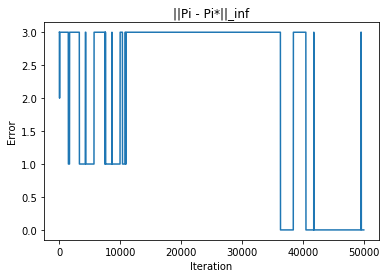

In [0]:
plot_infnorm(pi_all, pi_all[-1], name="Pi")

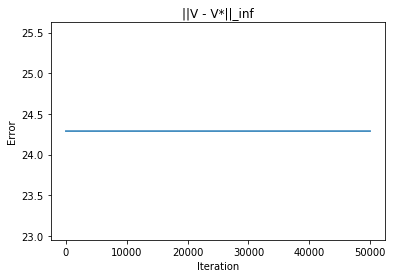

In [0]:
pi = sparsify_policy(pi_all[-1], Na=env.Na)
Ppi = np.sum(env.P * np.expand_dims(pi, axis=-1), axis=1)
Rpi = np.sum(env.R * pi, axis=1)

v_star = np.linalg.inv( np.identity(env.Ns) - gamma*Ppi).dot(Rpi)

v_all = []
for dpi_prev, q_prev in zip(pi_all, q_all):
  pi_prev = sparsify_policy(dpi_prev, Na=env.Na)
  v_prev = np.sum(pi_prev*q_prev, axis=1)
  v_all.append(v_prev)


# You may notive that some states have a high errors (especially the one with the negative rewards)
# Indeed, as there are less and less explored, the Q-values in "bad" states are not updated anymore as they are avoided by the agent.
plot_infnorm(v_all, v_star, name="V")


## Exercice: SARSA (Homework)
SARSA is another control algorithm. While Qlearning is off-policy, SARSA is on-policy.

1. Implement SARSA with softmax (Gibbs) exploration and test the convergence to $Q^\star$
2. Plot the value $\|V_n - V^\star\|_{\infty}$
3. Plot the expected cumulative reward of the algorithms: $t \mapsto \sum_{i=1}^t r_i$

# Remarks !!! 

Maximum score is 4

The mark is computed as follow:
- No code or q-learning code : -4pts
- The exploration strategy is wrong: -1.5pts
- The q-update is wrong: -1.5pts
- The q-update bootstrap next_state/next_action when `done=True`: -0.5pt
- Epsilon (or temperature) is not decreasing over time: -0.5pt
- The learning rate $\alpha$ is not decreasing over time: -0.5pt
- There is a greedy implementation of SARSA: -0.25pt
- Epsilon and/or learning rate are linearly decreasing (too fast): -0.25pt

Note: There were two (voluntary!) traps in the class interface: 
 - the `done` flag have to be added
 - the `greedy` flag have to be removed

Note that several people point it out :) Gj!

\\

\\
The common mistakes are the following

\\

**Mistake one:** *Incorrect bootstrapping when in the last state*

Imagine that you are in the last state, there is thus no next_state. As a result, you should not compute Q(next_state, next_action) in the TD error
In practice, the environment return a dummy next_state and the `done` flag so you can cancel the bootstrap when needed. 

```
    if not done:
      next_q = self.Q[next_state, next_action]
    else:
      next_q = 0.  # We do not bootstrap further
```

\\

**Mistake two:** *Incorrect sample_action function*

In Sarsa, you have two policies: 
 - The greedy-epsilon policy
 - The softmax policy

As opposed to Q-learning, Sarsa follows the same policy as training/evaluation time. There is no epxloration policy vs. exploitation policy as in Q-learning!

Thus, the flag `greedy` should be removed

The greedy policy is implemented as follow:

```
if np.random.uniform(0, 1) < epsilon:
  action = np.random.choice(self.env.actions)
else:
  action = self.Q[state, :].argmax()
return action
```

The softmax policy is implemented as follow:

```
def softmax(self,x):
  return np.exp(x) / np.sum(np.exp(x))

policy = self.softmax(q/temperature)
action = np.random.choice(self.env.actions, p=policy)
```

In both cases, it is very important to reduce epsilon (or temperature) to converge towards a determinist (optimal) policy. . Note that the exploration should not decreased too fast! A good spped/implementation is the following:

```
epsilon = self.epsilon / math.sqrt(self.Nsa[state].min())
```


\\
**Mistake three:** *No decreasing learning rate*

The learning rate must decrease during training to avoid oscillation while learning the q-function (cf slides). A good decreasing learning rate is:

```
alpha = self.learning_rate / math.sqrt(self.Nsa[state, action])
```

Linearly decreasing also works, but it is often a bit too strong in practice.



## Final Note
I also add another (more intuitive) implementation of sarsa below. 


In [0]:
# ---------------------------
# SARSA
# ---------------------------
class SARSA:
    """
    SARSA with deacreasing epsilon for exploration
    """
    def __init__(self, env, gamma, learning_rate, epsilon):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Q = np.zeros((env.Ns, env.Na))
        self.Nsa = np.ones((env.Ns, env.Na))
    
    def sample_action(self, state):  # There is no greedy sampling is Sarsa ;)

        # Epsilon keep decreasing, so you are always on-policy while exploring
        epsilon = self.epsilon / math.sqrt(self.Nsa[state].min())

        # Sample current policy
        if np.random.uniform(0, 1) < epsilon:
          action = np.random.choice(self.env.actions)
        else:
          action = self.Q[state, :].argmax()
        return action
        
    def update(self, state, action, next_state, next_action, reward, done):

        alpha = self.learning_rate / math.sqrt(self.Nsa[state, action])
        
        if not done:
          next_q = self.Q[next_state, next_action]
        else:
          next_q = 0.  # We do not bootstrap further
        
        q = self.Q[state, action]
        increment = (reward + self.gamma*next_q) - q

        # Update
        self.Q[state, action] = self.Q[state, action] + alpha*increment
        self.Nsa[state, action] += 1


In [0]:
agent = SARSA(env, gamma=env.gamma, learning_rate=1, epsilon=0.6)

# Define storage and variable
q_all = []
r_all = []
pi_all = []
max_steps = int(5e4)

# main algorithmic loop
state = env.reset()
action = agent.sample_action(state)

for t in range(max_steps):
    
  # Sample the environment
  next_state, reward, done, _ = env.step(action)
  next_action = agent.sample_action(next_state)

  # Update q-function
  agent.update(state=state, action=action, next_state=next_state, next_action=next_action, reward=reward, done=done)

  # Iterate
  state = next_state
  action = next_action
  if done:
    state = env.reset()

# Fake greedy policy (Greedy policy does not truly exist in Sarsa)
dpi = agent.Q.argmax(axis=1)
print(env.render_policy(dpi))


+-------+
|>:>:>:>|
|^:>:^:^|
|>:>:>:^|
+-------+
None


In [0]:
state = env.reset()
env.render()
for i in range(5):
    action = agent.sample_action(state)
    state, reward, done, _ = env.step(action)
    env.render()

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: : :_|
+-------+
  (right)
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (up)


In [0]:
# Procedural implementation


# Define a softmax function
def softmax(x):
  return np.exp(x) / np.sum(np.exp(x))
 

# Define storage and variable
max_steps = int(5e4)
gamma = 0.99
ini_learning_rate = 1. 
ini_temperature = 1.
Nsa = np.ones((env.Ns, env.Na))

# Intialize the agent
Q = np.zeros((env.Ns, env.Na))


# main algorithmic loop
state = env.reset()

policy = softmax(Q[state, :] / ini_temperature)
action = np.random.choice(env.actions, p=policy)

for t in range(max_steps):
    

  ### Sample the environment
  next_state, reward, done, _ = env.step(action)


  ### Sample the next action
  temperature = ini_temperature / math.sqrt(Nsa[state].min())
  policy = softmax(Q[next_state, :] / temperature)
  next_action = np.random.choice(env.actions, p=policy)


  ### Estimate the td error

  # Decrease learning rate
  alpha = ini_learning_rate / math.sqrt(Nsa[state, action])

  # Do not bootstrap when agent is in terminal state
  if not done:
    q = Q[state, action]
    next_q = Q[next_state, next_action]
  else:
    q = Q[state, action]
    next_q = 0.  

  # Compute td-error (beware of the minus)  
  td_increment= (reward + gamma*next_q) - q


  ### Update the agent
  Q[state, action] += alpha*td_increment
  Nsa[state, action] += 1


  ### Iterate
  state = next_state
  action = next_action
  if done:
    state = env.reset()

# Fake greedy policy (Greedy policy does not truly exist in Sarsa)
dpi = agent.Q.argmax(axis=1)
print(env.render_policy(dpi))



+-------+
|>:>:>:>|
|^:>:^:^|
|>:>:>:^|
+-------+
None
